In [1]:
import pandas as pd

# === Load the data ===
train_data = pd.read_csv("data_set_ALL_AML_train.csv")
independent_data = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv")

# === Function to drop 'call' columns and keep only expression values ===
def clean_expression_data(df):
    df = df.drop(columns=["Gene Description", "Gene Accession Number"])
    df = df.loc[:, ~df.columns.str.contains("call")]
    return df

train_expr = clean_expression_data(train_data)
indep_expr = clean_expression_data(independent_data)

# === Transpose data so rows = patients, columns = genes ===
train_expr_T = train_expr.T
indep_expr_T = indep_expr.T

# === Add patient ID as integer to merge with labels ===
train_expr_T['patient'] = train_expr_T.index.astype(int)
indep_expr_T['patient'] = indep_expr_T.index.astype(int)

# === Merge with actual cancer labels ===
train_labeled = pd.merge(train_expr_T, labels, on="patient")
indep_labeled = pd.merge(indep_expr_T, labels, on="patient")

# === Encode labels as binary (ALL = 0, AML = 1) ===
train_labeled["target"] = train_labeled["cancer"].map({"ALL": 0, "AML": 1})
indep_labeled["target"] = indep_labeled["cancer"].map({"ALL": 0, "AML": 1})

# === Preview ===
print(train_labeled.head())


     0    1    2    3    4    5    6    7    8    9  ...  7122  7123  7124  \
0 -214 -153  -58   88 -295 -558  199 -176  252  206  ...   389   -37   793   
1 -139  -73   -1  283 -264 -400 -330 -168  101   74  ...   442   -17   782   
2  -76  -49 -307  309 -376 -650   33 -367  206 -215  ...   168    52  1138   
3 -135 -114  265   12 -419 -585  158 -253   49   31  ...   174  -110   627   
4 -106 -125  -76  168 -230 -284    4 -122   70  252  ...   504   -26   250   

   7125  7126  7127  7128  patient  cancer  target  
0   329    36   191   -37        1     ALL       0  
1   295    11    76   -14        2     ALL       0  
2   777    41   228   -41        3     ALL       0  
3   170   -50   126   -91        4     ALL       0  
4   314    14    56   -25        5     ALL       0  

[5 rows x 7132 columns]


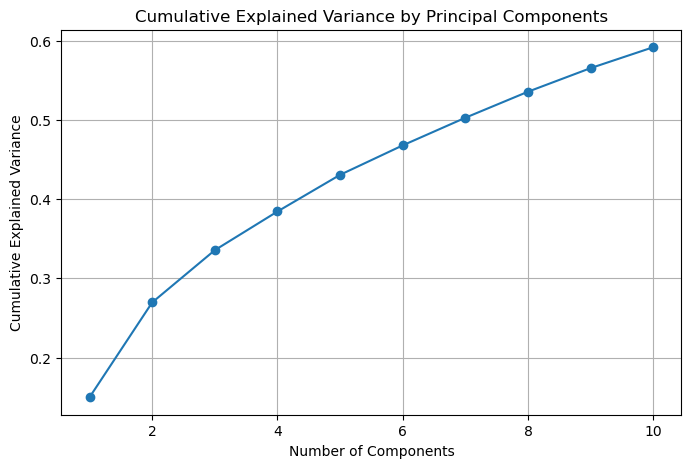

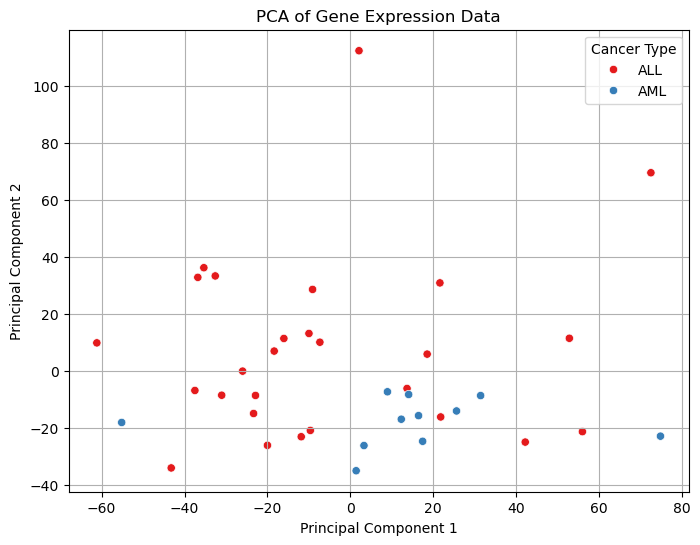

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Extract features and labels ===
X = train_labeled.drop(columns=["patient", "cancer", "target"])
y = train_labeled["target"]

# === Step 2: Standardize the features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 3: Apply PCA ===
pca = PCA(n_components=10)  # You can increase this if needed
X_pca = pca.fit_transform(X_scaled)

# === Step 4: Explained Variance Plot ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# === Step 5: PCA Scatter Plot (PC1 vs PC2) ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y.map({0: 'ALL', 1: 'AML'}), palette='Set1')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Gene Expression Data")
plt.legend(title='Cancer Type')
plt.grid(True)
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === Reuse top N PCA components ===
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
y = train_labeled["target"]

# === Define pipeline: PCA + Logistic Regression ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),          # standardize again in case of new data
    ('pca', PCA(n_components=n_components)),
    ('clf', LogisticRegression(max_iter=1000))
])

# === Cross-validation ===
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.3f}")

# === Fit model and evaluate on training set ===
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

# === Evaluation ===
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["ALL", "AML"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Cross-validated accuracy scores: [0.75  1.    0.875 1.    1.   ]
Mean accuracy: 0.925

Classification Report:
              precision    recall  f1-score   support

         ALL       1.00      1.00      1.00        27
         AML       1.00      1.00      1.00        11

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


Confusion Matrix:
[[27  0]
 [ 0 11]]


In [4]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === Prepare training data ===
X_train = train_labeled.drop(columns=["patient", "cancer", "target"])
y_train = train_labeled["target"]

# === Prepare test data ===
X_test = indep_labeled.drop(columns=["patient", "cancer", "target"])
y_test = indep_labeled["target"]

# === Define pipeline: StandardScaler + PCA + Logistic Regression ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # You can adjust this
    ('clf', LogisticRegression(max_iter=1000))
])

# === Fit the model on the training set ===
pipeline.fit(X_train, y_train)

# === Predict on the test set ===
y_pred_test = pipeline.predict(X_test)

# === Evaluate performance ===
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=["ALL", "AML"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Test Accuracy: 0.824

Classification Report:
              precision    recall  f1-score   support

         ALL       0.77      1.00      0.87        20
         AML       1.00      0.57      0.73        14

    accuracy                           0.82        34
   macro avg       0.88      0.79      0.80        34
weighted avg       0.86      0.82      0.81        34

Confusion Matrix:
[[20  0]
 [ 6  8]]


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# === Features and labels ===
X_train = train_labeled.drop(columns=["patient", "cancer", "target"])
y_train = train_labeled["target"]
X_test = indep_labeled.drop(columns=["patient", "cancer", "target"])
y_test = indep_labeled["target"]

# === Optional: standardize features (not strictly necessary for trees) ===
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# === Random Forest Classifier ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("\n--- Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.3f}")
print("Classification Report:")
print(classification_report(y_test, rf_preds, target_names=["ALL", "AML"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

# === XGBoost Classifier ===
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("\n--- XGBoost Results ---")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds):.3f}")
print("Classification Report:")
print(classification_report(y_test, xgb_preds, target_names=["ALL", "AML"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_preds))



--- Random Forest Results ---
Accuracy: 0.735
Classification Report:
              precision    recall  f1-score   support

         ALL       0.69      1.00      0.82        20
         AML       1.00      0.36      0.53        14

    accuracy                           0.74        34
   macro avg       0.84      0.68      0.67        34
weighted avg       0.82      0.74      0.70        34

Confusion Matrix:
[[20  0]
 [ 9  5]]

--- XGBoost Results ---
Accuracy: 0.912
Classification Report:
              precision    recall  f1-score   support

         ALL       0.95      0.90      0.92        20
         AML       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

Confusion Matrix:
[[18  2]
 [ 1 13]]



Top 30 Important Genes (by feature index):

Gene 4846: importance = 1.00000
Gene 7128: importance = 0.00000
Gene 2380: importance = 0.00000
Gene 2369: importance = 0.00000
Gene 2370: importance = 0.00000
Gene 2371: importance = 0.00000
Gene 2372: importance = 0.00000
Gene 2373: importance = 0.00000
Gene 2374: importance = 0.00000
Gene 2375: importance = 0.00000
Gene 2376: importance = 0.00000
Gene 2377: importance = 0.00000
Gene 2378: importance = 0.00000
Gene 2379: importance = 0.00000
Gene 2381: importance = 0.00000
Gene 2394: importance = 0.00000
Gene 2382: importance = 0.00000
Gene 2383: importance = 0.00000
Gene 2384: importance = 0.00000
Gene 2385: importance = 0.00000
Gene 2386: importance = 0.00000
Gene 2387: importance = 0.00000
Gene 2388: importance = 0.00000
Gene 2389: importance = 0.00000
Gene 2390: importance = 0.00000
Gene 2391: importance = 0.00000
Gene 2392: importance = 0.00000
Gene 2368: importance = 0.00000
Gene 2367: importance = 0.00000
Gene 2366: importance = 0.0

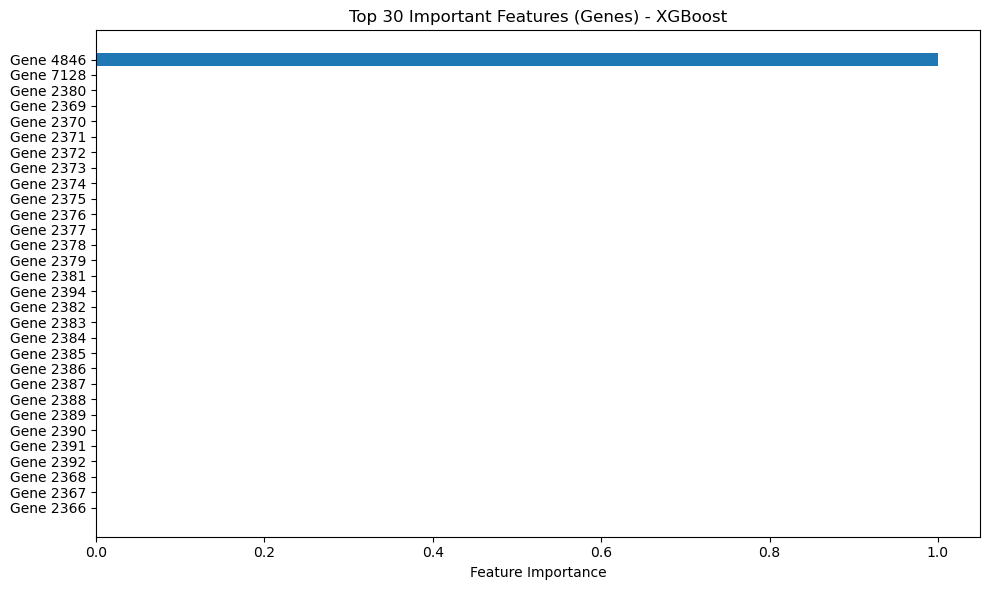

In [8]:
# Get feature importances from XGBoost
importances = xgb.feature_importances_
top_n = 30
top_indices = np.argsort(importances)[-top_n:][::-1]

# Print top features and importance values
print(f"\nTop {top_n} Important Genes (by feature index):\n")
for i in top_indices:
    print(f"Gene {i}: importance = {importances[i]:.5f}")

# Optional: plot if memory allows
try:
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_indices)), importances[top_indices], align='center')
    plt.yticks(np.arange(len(top_indices)), [f"Gene {i}" for i in top_indices])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Important Features (Genes) - XGBoost")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except MemoryError:
    print("Plotting skipped due to memory error.")

In [9]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Step 1: Compute variance for each gene
gene_variances = X_train.var(axis=0)

# Step 2: Select top 500 genes by variance
top_500_indices = gene_variances.sort_values(ascending=False).index[:500]

# Step 3: Subset both train and test sets
X_train_reduced = X_train[top_500_indices]
X_test_reduced = X_test[top_500_indices]

# Step 4: Retrain XGBoost on reduced feature set
xgb_reduced = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = xgb_reduced.predict(X_test_reduced)

# Step 5: Evaluate
print("\n--- XGBoost (Top 500 Most Variable Genes) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_reduced, target_names=["ALL", "AML"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_reduced))


--- XGBoost (Top 500 Most Variable Genes) ---
Accuracy: 0.912
Classification Report:
              precision    recall  f1-score   support

         ALL       0.95      0.90      0.92        20
         AML       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

Confusion Matrix:
[[18  2]
 [ 1 13]]


In [13]:
# Get feature importances from the reduced model
importances_reduced = xgb_reduced.feature_importances_
top_indices_reduced = np.argsort(importances_reduced)[-30:][::-1]

# Show top genes used in the reduced model
print("Top 30 Gene Importances (from top 500 gene model):\n")
for i in top_indices_reduced:
    print(f"Gene {top_500_indices[i]} (reduced index {i}): importance = {importances_reduced[i]:.5f}")


Top 30 Gene Importances (from top 500 gene model):

Gene 3257 (reduced index 212): importance = 0.29907
Gene 4327 (reduced index 202): importance = 0.27671
Gene 1881 (reduced index 35): importance = 0.15858
Gene 6040 (reduced index 418): importance = 0.12654
Gene 1684 (reduced index 157): importance = 0.06028
Gene 4846 (reduced index 385): importance = 0.04713
Gene 4376 (reduced index 402): importance = 0.02522
Gene 1927 (reduced index 346): importance = 0.00274
Gene 1119 (reduced index 416): importance = 0.00136
Gene 2120 (reduced index 197): importance = 0.00129
Gene 2353 (reduced index 207): importance = 0.00040
Gene 5771 (reduced index 240): importance = 0.00037
Gene 6217 (reduced index 305): importance = 0.00032
Gene 2641 (reduced index 162): importance = 0.00000
Gene 6730 (reduced index 156): importance = 0.00000
Gene 1372 (reduced index 178): importance = 0.00000
Gene 3360 (reduced index 177): importance = 0.00000
Gene 46 (reduced index 158): importance = 0.00000
Gene 911 (reduc

In [11]:
# Map top indices back to gene names
gene_metadata = train_data[["Gene Description", "Gene Accession Number"]]

# Example: Find info for Gene 4846
gene_info = gene_metadata.iloc[4846]
print(gene_info)

Gene Description             Zyxin
Gene Accession Number    X95735_at
Name: 4846, dtype: object


In [12]:
xgb_reduced = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.5,
    reg_alpha=1.0,   # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    eval_metric='logloss',
    random_state=42
)
xgb_reduced.fit(X_train_reduced, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train)

importances_rf = rf.feature_importances_
top_rf_indices = np.argsort(importances_rf)[-20:][::-1]

for i in top_rf_indices:
    print(f"Gene {top_500_indices[i]}: importance = {importances_rf[i]:.5f}")

Gene 2120: importance = 0.04740
Gene 4846: importance = 0.04567
Gene 6217: importance = 0.04365
Gene 2591: importance = 0.03948
Gene 759: importance = 0.03766
Gene 311: importance = 0.03111
Gene 6040: importance = 0.03048
Gene 2287: importance = 0.02888
Gene 4327: importance = 0.02499
Gene 1703: importance = 0.02461
Gene 2110: importance = 0.02364
Gene 3136: importance = 0.02348
Gene 3055: importance = 0.02183
Gene 5969: importance = 0.02134
Gene 4168: importance = 0.02133
Gene 6802: importance = 0.02022
Gene 4210: importance = 0.01892
Gene 1248: importance = 0.01854
Gene 4376: importance = 0.01782
Gene 5771: importance = 0.01775


In [15]:
# gene_metadata contains names/descriptions from the original dataset
gene_metadata = train_data[["Gene Description", "Gene Accession Number"]]

# List of top gene indices from Random Forest
top_gene_indices = [2120, 4846, 6217, 2591, 759, 311, 6040, 2287, 4327, 1703,
                    2110, 3136, 3055, 5969, 4168, 6802, 4210, 1248, 4376, 5771]

# Extract and print corresponding gene info
top_genes_info = gene_metadata.iloc[top_gene_indices]
print(top_genes_info)


                                       Gene Description Gene Accession Number
2120     CTSD Cathepsin D (lysosomal aspartyl protease)             M63138_at
4846                                              Zyxin             X95735_at
6217                       ELA2 Elastatse 2; neutrophil           M27783_s_at
2591            Pre-B cell enhancing factor (PBEF) mRNA             U02020_at
759                                          CYSTATIN A             D88422_at
311                              NADPH-flavin reductase             D26308_at
6040   APLP2 Amyloid beta (A4) precursor-like protein 2           L09209_s_at
2287             DF D component of complement (adipsin)             M84526_at
4327                              PROTEASOME IOTA CHAIN             X59417_at
1703                            ADA Adenosine deaminase             M13792_at
2110    ATP6C Vacuolar H+ ATPase proton channel subunit             M62762_at
3136           Stimulator of TAR RNA binding (SRB) mRNA         